# Hyper paramete tuning & make classifiers

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from scipy import stats
import re,sys,os
from collections import defaultdict, Counter
from matplotlib import patches

In [5]:
from sklearn.neighbors import KNeighborsClassifier as KN
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import joblib

In [ ]:
print(sys.version)

In [6]:
%pip list | grep -e "numpy" -e "pandas" -e "matplotlib" -e "scipy" -e "seaborn" -e "scikit-learn" -e "joblib"

joblib                            1.0.1
matplotlib                        3.3.4
numpy                             1.19.5
pandas                            1.2.3
scikit-learn                      0.24.1
scipy                             1.6.1
seaborn                           0.11.1
You should consider upgrading via the '/Users/takamatsushiro/.pyenv/versions/3.7.4/envs/MSigPred_2021/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [7]:
plt.style.use('seaborn-white')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
# change default figure size
plt.rcParams['figure.figsize']=4,3
plt.rcParams["figure.dpi"]=300
# change default font size

SMALL_SIZE = 7
MEDIUM_SIZE = 8
LARGE_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=0.5) 
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  


In [8]:
cluster_order=["SMK","UVL","APB","POL","MRD","HRD","GNS","AGE"]
cluster_color=['red', 'blue', 'green', "brown", 'purple', 'hotpink',"c",'y']
cluster_order2=["SMK","UVL","APB","POL","MRD","HRD","GNS","AGE","UND"]
cluster_color2=['red', 'blue', 'green', "brown", 'purple', 'hotpink',"c",'y',"grey"]

In [9]:
store="../results/"

In [10]:
with open(store+"TCGA_7181_cluster_numbers.tsv") as f:
    cluster_numbers=f.read().splitlines()

In [11]:
with open(store+"TCGA_7181_cluster_colors.tsv") as f:
    cluster_colors=f.read().splitlines()

In [12]:
with open(store+"TCGA_7181_cluster_annotations.tsv") as f:
    cluster_anno=f.read().splitlines()

In [13]:
# import data
df_mutsig=pd.read_csv(store+"TCGA_7181_df_mutsig_log10.tsv",sep="\t",index_col=0)
df_mutsig.head()

,Sig_1,Sig_2,Sig_3,Sig_4,Sig_5,Sig_6,Sig_7,Sig_8,Sig_9,Sig_10,Sig_11,Sig_12,Sig_13,Sig_14,Sig_15,Sig_16,Sig_17,Sig_18,Sig_19,Sig_20,Sig_21,Sig_22,Sig_23,Sig_24,Sig_25,Sig_26,Sig_27,Sig_28,Sig_29,Sig_30
TCGA-75-5126,1.334063,1.875021,0.0,2.661550,0.0,0.286575,0.863936,0.0,0.0,0.710120,0.0,0.0,1.895948,0.0,0.0,0.0,0.00000,1.368333,0.0,1.755399,0.0,1.002302,0.0,0.0,0.0,0.0,0.816736,0.167481,0.0,0.0
TCGA-05-4410,1.793566,1.885999,0.0,2.992602,0.0,0.000000,1.310370,0.0,0.0,0.000000,0.0,0.0,1.802393,0.0,0.0,0.0,0.00000,0.000000,0.0,1.729939,0.0,1.310326,0.0,0.0,0.0,0.0,0.000000,0.119172,0.0,0.0
TCGA-OR-A5JB,1.178243,1.672223,0.0,2.429289,0.0,0.000000,0.979917,0.0,0.0,0.000000,0.0,0.0,1.604990,0.0,0.0,0.0,0.00000,0.000000,0.0,1.444871,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
TCGA-62-8399,1.654268,1.927778,0.0,2.491066,0.0,1.498923,0.000000,0.0,0.0,1.095529,0.0,0.0,2.072570,0.0,0.0,0.0,0.86331,0.237051,0.0,1.435106,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
TCGA-33-6737,0.000000,1.799645,0.0,2.368170,0.0,1.444228,1.585332,0.0,0.0,1.102891,0.0,0.0,2.170894,0.0,0.0,0.0,0.00000,0.000000,0.0,1.593119,0.0,0.000000,0.0,0.0,0.0,0.0,0.502234,0.000000,0.0,0.0


# Hyper parameter tuning
Depending on environment, the following section will take a considerable computation time.

## KN

In [18]:
best_params=[]
test_accs=[]
X=df_mutsig
Y=cluster_anno
clf=KN()
param_grid={"n_neighbors":[1,3,5,7,9,],"weights":["uniform","distance"]}
for i in range(100):
    RANDOM_SEED=i
    # Split samples half and half
    X1, X2, y1, y2= train_test_split( X, Y, random_state=RANDOM_SEED,test_size=0.5)
    # using X1 for Train + Validation, X2 as Test data
    grid_search=GridSearchCV(clf,param_grid,cv=2,n_jobs=-1)
    grid_search.fit(X1,y1)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X2,y2),4) )
    # swap X1 and X2
    grid_search.fit(X2,y2)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X1,y1),4) )

In [19]:
df_best_params=pd.DataFrame(best_params)
df_best_params.loc[:,"Test data acc"]=test_accs
df_best_params

,n_neighbors,weights,Test data acc
0,3,distance,0.9429
1,7,distance,0.9457
2,9,distance,0.9496
3,7,distance,0.9354
4,3,distance,0.9401
...,...,...,...
195,3,distance,0.9423
196,5,distance,0.9440
197,5,distance,0.9401
198,3,distance,0.9379


In [20]:
pd.crosstab(df_best_params["n_neighbors"],df_best_params["weights"])

weights,distance
n_neighbors,
3,51
5,87
7,49
9,13


### adopted n=5, weights="distance"

## LR

### first
C from 0.01,0.1,1,10,100

In [15]:
best_params=[]
test_accs=[]
X=df_mutsig
Y=cluster_anno
clf=LR(max_iter=2000)
param_grid={"C":[0.01,0.1,1,10,100]}
for i in range(100):
    RANDOM_SEED=i
    # Split samples half and half
    X1, X2, y1, y2= train_test_split( X, Y, random_state=RANDOM_SEED,test_size=0.5)
    # using X1 for Train + Validation, X2 as Test data
    grid_search=GridSearchCV(clf,param_grid,cv=2,n_jobs=-1)
    grid_search.fit(X1,y1)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X2,y2),4) )
    # swap X1 and X2
    grid_search.fit(X2,y2)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X1,y1),4) )

In [16]:
res_test=pd.DataFrame( {"Best params":[str(x) for x in best_params], "Test data acc":test_accs})

<AxesSubplot:xlabel='Best params', ylabel='Test data acc'>

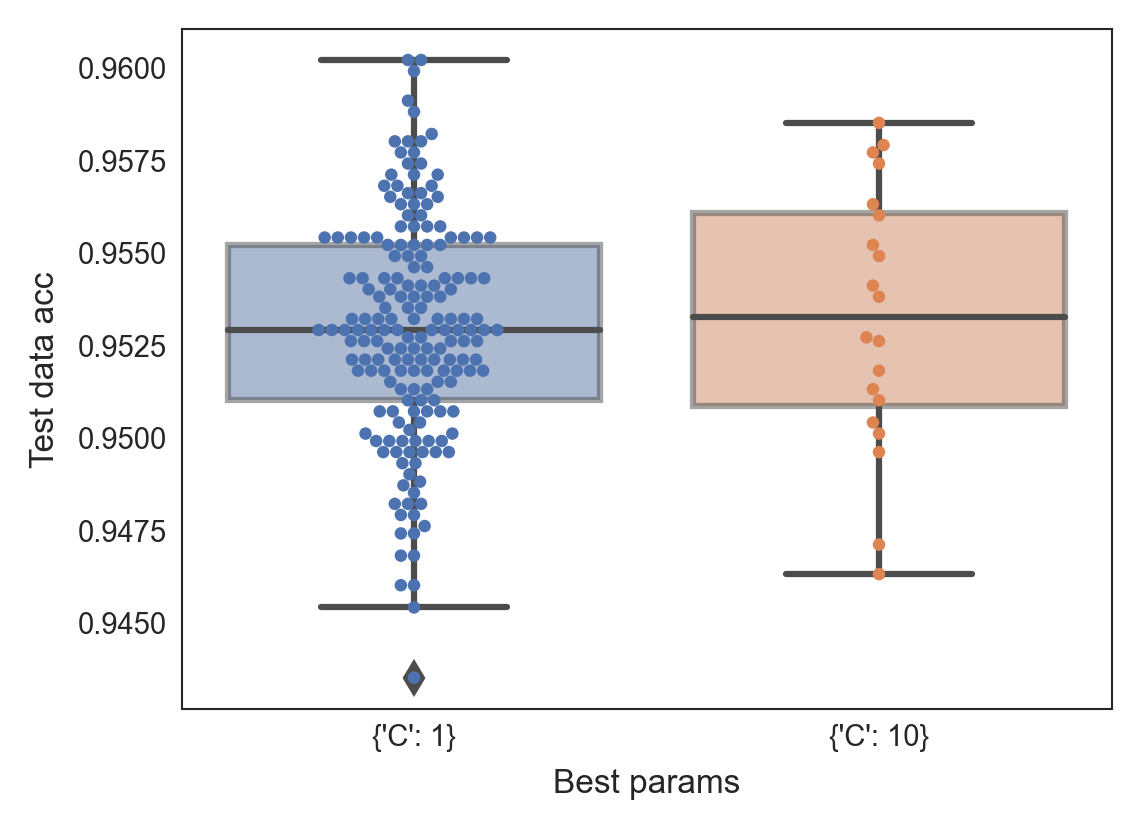

In [17]:
sns.swarmplot(x="Best params",y="Test data acc",data=res_test,s=3)
sns.boxplot(x="Best params",y="Test data acc",data=res_test,boxprops={"alpha":0.5})

### second
C from 0.5, 1, 2, 5

In [143]:
best_params=[]
test_accs=[]
X=df_mutsig
Y=cluster_anno
clf=LR(max_iter=2000)
param_grid={"C":[0.5,1,2,5]}
for i in range(100):
    RANDOM_SEED=i
    # Split samples half and half
    X1, X2, y1, y2= train_test_split( X, Y, random_state=RANDOM_SEED,test_size=0.5)
    # using X1 for Train + Validation, X2 as Test data
    grid_search=GridSearchCV(clf,param_grid,cv=2,n_jobs=-1)
    grid_search.fit(X1,y1)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X2,y2),4) )
    # swap X1 and X2
    grid_search.fit(X2,y2)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X1,y1),4) )

In [145]:
df_best_params=pd.DataFrame(best_params)
df_best_params.loc[:,"Test data acc"]=test_accs
df_best_params

,C,Test data acc
0,1.0,0.9549
1,5.0,0.9521
2,2.0,0.9549
3,0.5,0.9496
4,0.5,0.9560
...,...,...
195,1.0,0.9515
196,5.0,0.9532
197,5.0,0.9535
198,5.0,0.9471


In [147]:
Counter(df_best_params["C"])

Counter({1.0: 65, 5.0: 27, 2.0: 49, 0.5: 59})

<AxesSubplot:xlabel='Best params', ylabel='Test data acc'>

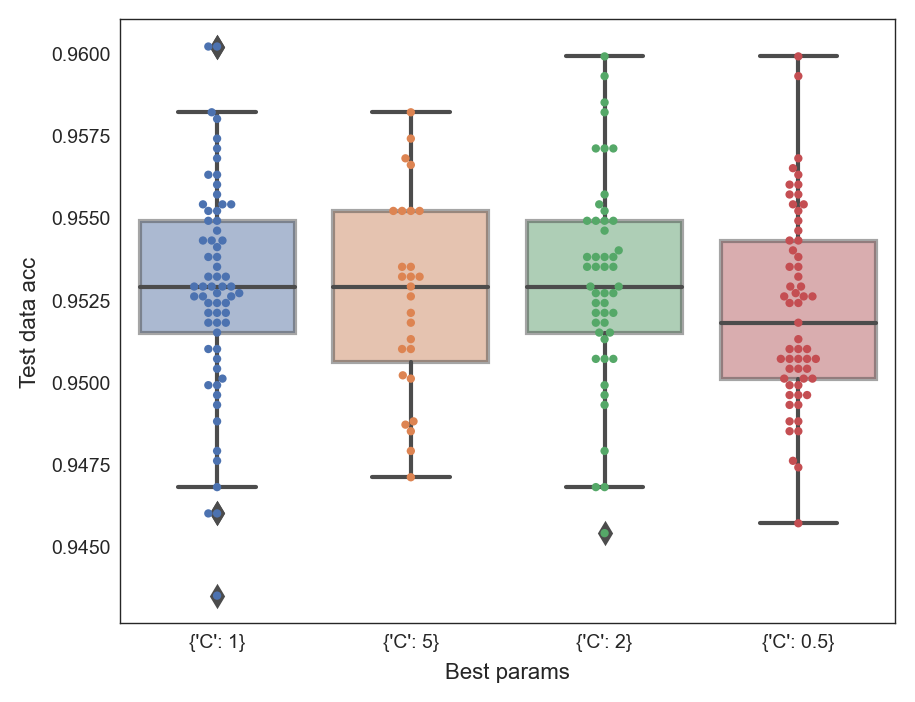

In [146]:
res_test=pd.DataFrame( {"Best params":[str(x) for x in best_params], "Test data acc":test_accs})
sns.swarmplot(x="Best params",y="Test data acc",data=res_test,s=3)
sns.boxplot(x="Best params",y="Test data acc",data=res_test,boxprops={"alpha":0.5})

### Finally adopted C=1

## SVC

### first
"C":[0.1, 1,10],"gamma":[0.01,0.1,1]

In [66]:
best_params=[]
test_accs=[]
X=df_mutsig
Y=cluster_anno
clf=SVC()
param_grid={"C":[0.1, 1,10],"gamma":[0.01,0.1,1],""}
for i in range(100):
    RANDOM_SEED=i
    # Split samples half and half
    X1, X2, y1, y2= train_test_split( X, Y, random_state=RANDOM_SEED,test_size=0.5)
    # using X1 for Train + Validation, X2 as Test data
    grid_search=GridSearchCV(clf,param_grid,cv=2,n_jobs=-1)
    grid_search.fit(X1,y1)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X2,y2),4) )
    # swap X1 and X2
    grid_search.fit(X2,y2)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X1,y1),4) )

In [67]:
df_best_params=pd.DataFrame(best_params)
df_best_params.loc[:,"Test data acc"]=test_accs
df_best_params

,C,gamma,Test data acc
0,1,0.1,0.9638
1,1,0.1,0.9649
2,1,0.1,0.9669
3,1,0.1,0.9574
4,1,0.1,0.9649
5,1,0.1,0.9599
6,1,0.1,0.9585
7,1,0.1,0.9680
8,1,0.1,0.9624
9,1,0.1,0.9602


In [68]:
pd.crosstab(df_best_params["C"],df_best_params["gamma"])

gamma,0.1
C,
1,37
10,3


### second
{"C":[0.5,1,5],"gamma":[0.05,0.1,0.3]}

In [69]:
best_params=[]
test_accs=[]
X=df_mutsig
Y=cluster_anno
clf=SVC()
param_grid={"C":[0.5, 1,5],"gamma":[0.05,0.1,0.3]}
for i in range(100):
    RANDOM_SEED=i
    # Split samples half and half
    X1, X2, y1, y2= train_test_split( X, Y, random_state=RANDOM_SEED,test_size=0.5)
    # using X1 for Train + Validation, X2 as Test data
    grid_search=GridSearchCV(clf,param_grid,cv=2,n_jobs=-1)
    grid_search.fit(X1,y1)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X2,y2),4) )
    # swap X1 and X2
    grid_search.fit(X2,y2)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X1,y1),4) )

In [70]:
df_best_params=pd.DataFrame(best_params)
df_best_params.loc[:,"Test data acc"]=test_accs
df_best_params["C_gamma"]=[ str(df_best_params.loc[idx,"C"])+"_"+str(df_best_params.loc[idx,"gamma"]) for idx in df_best_params.index]
pd.crosstab(df_best_params["C"],df_best_params["gamma"])

gamma,0.05,0.10
C,,
0.5,1,4
1.0,5,20
5.0,4,6


### third
{"C":[0.75,1,3],"gamma":[0.075,0.1,0.15,}

In [90]:
best_params=[]
test_accs=[]
X=df_mutsig
Y=cluster_anno
clf=SVC()
param_grid={"C":[0.5,0.75,1,3],"gamma":[0.05, 0.075,0.1,0.15]}
for i in range(100):
    RANDOM_SEED=i
    # Split samples half and half
    X1, X2, y1, y2= train_test_split( X, Y, random_state=RANDOM_SEED,test_size=0.5)
    # using X1 for Train + Validation, X2 as Test data
    grid_search=GridSearchCV(clf,param_grid,cv=2,n_jobs=-1)
    grid_search.fit(X1,y1)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X2,y2),4) )
    # swap X1 and X2
    grid_search.fit(X2,y2)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X1,y1),4) )

In [91]:
df_best_params=pd.DataFrame(best_params)
df_best_params.loc[:,"Test data acc"]=test_accs
df_best_params["C_gamma"]=[ str(df_best_params.loc[idx,"C"])+"_"+str(df_best_params.loc[idx,"gamma"]) for idx in df_best_params.index]
pd.crosstab(df_best_params["C"],df_best_params["gamma"])

gamma,0.050,0.075,0.100,0.150
C,,,,
0.50,2,3,2,0
0.75,5,5,6,1
1.00,0,11,8,4
3.00,3,7,2,1


### forth
{"C":[0.75,1,2],"gamma":[0.075,0.1,0.125}

In [106]:
best_params=[]
test_accs=[]
X=df_mutsig
Y=cluster_anno
clf=SVC()
param_grid={"C":[0.75,1,2],"gamma":[0.075,0.1,0.125]}
for i in range(100):
    RANDOM_SEED=i
    # Split samples half and half
    X1, X2, y1, y2= train_test_split( X, Y, random_state=RANDOM_SEED,test_size=0.5)
    # using X1 for Train + Validation, X2 as Test data
    grid_search=GridSearchCV(clf,param_grid,cv=2,n_jobs=-1)
    grid_search.fit(X1,y1)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X2,y2),4) )
    # swap X1 and X2
    grid_search.fit(X2,y2)
    best_params.append( grid_search.best_params_)
    test_accs.append( np.round( grid_search.score(X1,y1),4) )

In [107]:
df_best_params=pd.DataFrame(best_params)
df_best_params.loc[:,"Test data acc"]=test_accs
df_best_params["C_gamma"]=[ str(df_best_params.loc[idx,"C"])+"_"+str(df_best_params.loc[idx,"gamma"]) for idx in df_best_params.index]
pd.crosstab(df_best_params["C"],df_best_params["gamma"])

gamma,0.075,0.100,0.125
C,,,
0.75,16,9,7
1.00,10,15,13
2.00,10,10,10


<AxesSubplot:xlabel='C_gamma', ylabel='Test data acc'>

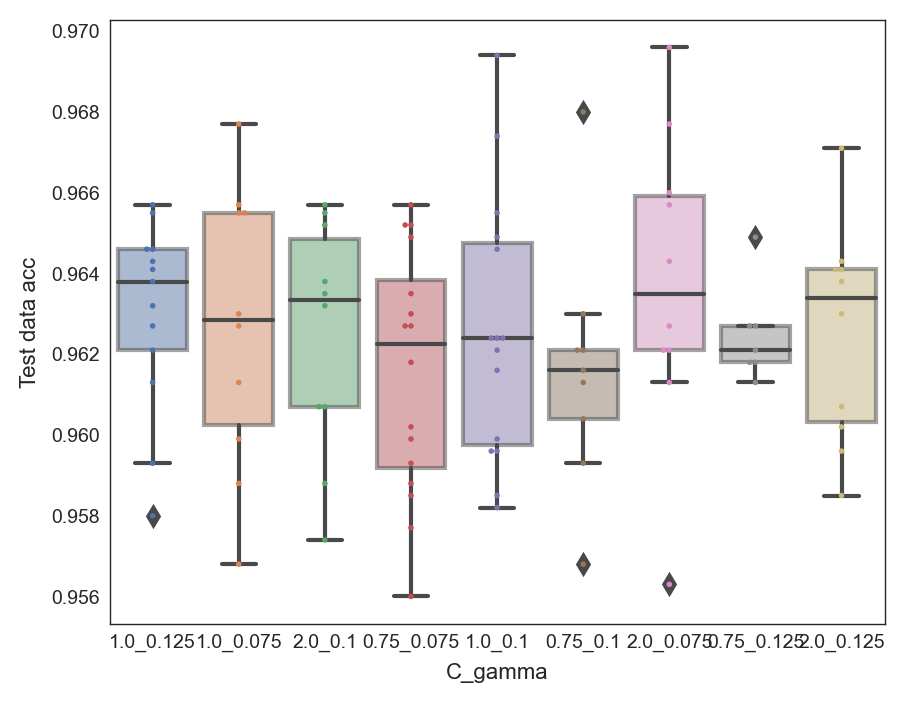

In [108]:
sns.swarmplot(x="C_gamma",y="Test data acc",data=df_best_params,s=2)
sns.boxplot(x="C_gamma",y="Test data acc",data=df_best_params,boxprops={"alpha":0.5})

### Finally adopted  C=1, gamma=0.1

## RF
Since parameter tuning for RFCs did not change the predictability much, we adopted the default values.

# Make Classifiers from all data

In [24]:
RANDOM_SEED=1
X=df_mutsig
Y=cluster_anno

In [25]:
# set parameters
knc=KN(n_neighbors=5,  weights='distance')
svc=SVC( kernel="rbf",C=1,gamma=0.1 )
rfc=RF( n_estimators=100, criterion='gini')
lrc=LR( C=1.0,max_iter=2000)

In [26]:
lrc.fit(X,Y)
joblib.dump(lrc,store+"TCGA_7181_lrc_c1.joblib")
knc.fit(X,Y)
joblib.dump(knc,store+"TCGA_7181_knn_n5_dis.joblib")
svc.fit(X,Y)
joblib.dump(svc,store+"TCGA_7181_svc_c1_g01.joblib")
rfc.fit(X,Y)
joblib.dump(rfc,store+"TCGA_7181_rfc_ne100.joblib")

['../results/TCGA_7181_rfc_ne100.joblib']

# Check performance

In [27]:
RANDOM_SEED=2
X=df_mutsig
Y=cluster_anno
X1, X2, y1, y2= train_test_split( X, Y, random_state=RANDOM_SEED,test_size=0.25)

In [28]:
from matplotlib.colors import LinearSegmentedColormap
wr=LinearSegmentedColormap.from_list('wr', [(0,"w"),(1,"red")] )

## KNC

In [58]:
knc.fit(X1,y1)
pred=knc.predict(X2)
pred_train=knc.predict(X1)

In [60]:
from  sklearn.metrics import confusion_matrix
cm=confusion_matrix(pred, y2,labels=cluster_order)
cm=pd.DataFrame(cm,index=cluster_order,columns=cluster_order)
cm

,SMK,UVL,APB,POL,MRD,HRD,GNS,AGE
SMK,179,0,1,0,0,2,0,0
UVL,0,100,0,0,0,0,0,0
APB,0,0,231,0,1,4,1,1
POL,0,0,0,21,0,0,0,0
MRD,0,0,0,1,81,0,0,0
HRD,5,0,0,0,0,244,0,12
GNS,0,0,0,0,0,8,144,4
AGE,10,0,6,1,0,16,6,717


In [62]:
cm_norm=confusion_matrix(pred, y2,labels=cluster_order,normalize="true")
pd.DataFrame(cm_norm)

,0,1,2,3,4,5,6,7
0,0.983516,0.0,0.005495,0.000000,0.000000,0.010989,0.000000,0.000000
1,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,0.970588,0.000000,0.004202,0.016807,0.004202,0.004202
3,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0,0.000000,0.012195,0.987805,0.000000,0.000000,0.000000
5,0.019157,0.0,0.000000,0.000000,0.000000,0.934866,0.000000,0.045977
6,0.000000,0.0,0.000000,0.000000,0.000000,0.051282,0.923077,0.025641
7,0.013228,0.0,0.007937,0.001323,0.000000,0.021164,0.007937,0.948413


Text(30.750000000000004, 0.5, 'True label')

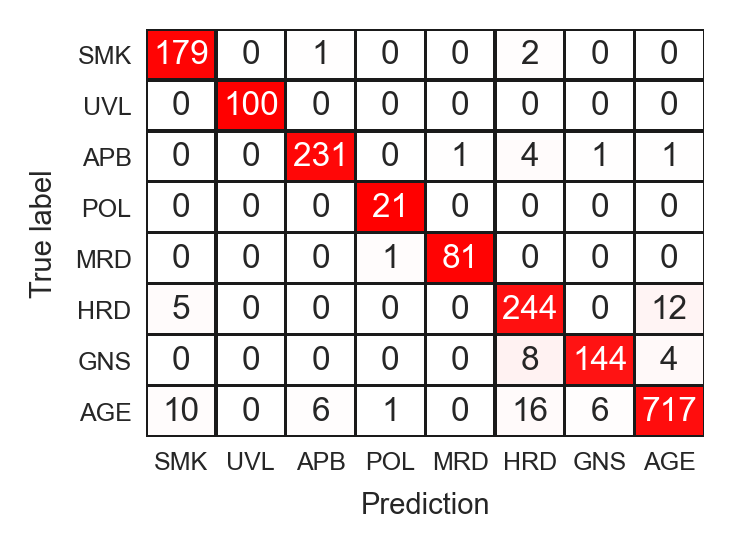

In [38]:
fig = plt.figure(figsize=(2.4,1.8))
ax = fig.add_subplot(1,1,1)
ax=sns.heatmap(data=cm_norm,vmin=0,vmax=1,
               annot=cm, cmap=wr, fmt="1d",
            annot_kws={"fontsize":8}
           ,cbar=False, linewidths=0.5,linecolor='k')
ax.set_title('',fontsize=7)
ax.set_xlabel('Prediction',fontsize=7)
ax.set_yticklabels(cluster_order,fontsize=6,rotation=0)
ax.set_xticklabels(cluster_order,fontsize=6,rotation=0)
ax.set_ylabel('True label',fontsize=7)
#plt.savefig(store+"Confusion_matrix_KN.png",dpi=300,bbox_inches="tight")

In [40]:
from  sklearn.metrics import accuracy_score
acc_test=accuracy_score(y_pred=pred, y_true=y2)
acc_train=accuracy_score(y_pred=pred_train, y_true=y1)
print("Training acc={:.3f}".format(acc_train))
print("Test acc={:.3f}".format(acc_test))

Training acc=1.000
Test acc=0.956


## SVC

In [43]:
svc.fit(X1,y1)
pred=svc.predict(X2)
pred_train=svc.predict(X1)

In [44]:
cm=confusion_matrix(pred, y2,labels=cluster_order)
cm=pd.DataFrame(cm,index=cluster_order,columns=cluster_order)
cm_norm=confusion_matrix(pred, y2,labels=cluster_order,normalize="true")
cm

,SMK,UVL,APB,POL,MRD,HRD,GNS,AGE
SMK,192,0,2,0,0,3,0,2
UVL,0,100,0,0,0,0,0,0
APB,0,0,232,0,0,1,2,3
POL,0,0,0,23,0,0,0,0
MRD,0,0,0,0,82,0,0,0
HRD,2,0,1,0,0,256,3,17
GNS,0,0,0,0,0,1,139,3
AGE,0,0,3,0,0,13,7,709


Text(30.750000000000004, 0.5, 'True label')

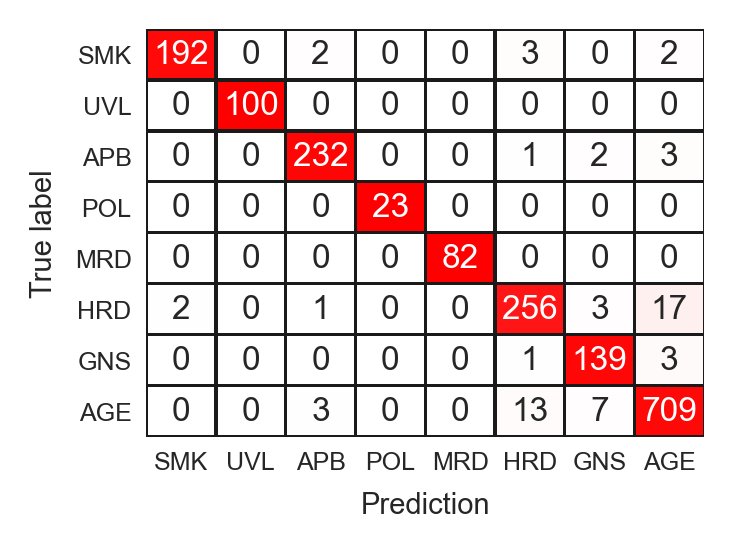

In [45]:
fig = plt.figure(figsize=(2.4,1.8))
ax = fig.add_subplot(1,1,1)
ax=sns.heatmap(data=cm_norm,vmin=0,vmax=1,
               annot=cm, cmap=wr, fmt="1d",
            annot_kws={"fontsize":8}
           ,cbar=False, linewidths=0.5,linecolor='k')
ax.set_title('',fontsize=7)
ax.set_xlabel('Prediction',fontsize=7)
ax.set_yticklabels(cluster_order,fontsize=6,rotation=0)
ax.set_xticklabels(cluster_order,fontsize=6,rotation=0)
ax.set_ylabel('True label',fontsize=7)
#plt.savefig(store+"Confusion_matrix_SVC.png",dpi=300,bbox_inches="tight")

In [48]:
acc_test=accuracy_score(y_pred=pred,y_true=y2)
acc_train=accuracy_score(y_pred=pred_train, y_true=y1)
print("Training acc={:.3f}".format(acc_train))
print("Test acc={:.3f}".format(acc_test))

Training acc=1.000
Test acc=0.955


## RFC

In [49]:
rfc.fit(X1,y1)
pred=rfc.predict(X2)
pred_train=rfc.predict(X1)

In [50]:
cm=confusion_matrix(pred, y2,labels=cluster_order)
cm=pd.DataFrame(cm,index=cluster_order,columns=cluster_order)
cm_norm=confusion_matrix(pred, y2,labels=cluster_order,normalize="true")
cm

,SMK,UVL,APB,POL,MRD,HRD,GNS,AGE
SMK,184,0,4,0,0,3,1,0
UVL,0,100,0,0,0,0,0,0
APB,2,0,224,0,1,3,2,3
POL,0,0,0,23,0,0,0,0
MRD,0,0,0,0,81,0,0,1
HRD,2,0,1,0,0,254,5,18
GNS,0,0,0,0,0,2,136,3
AGE,6,0,9,0,0,12,7,709


Text(30.750000000000004, 0.5, 'True label')

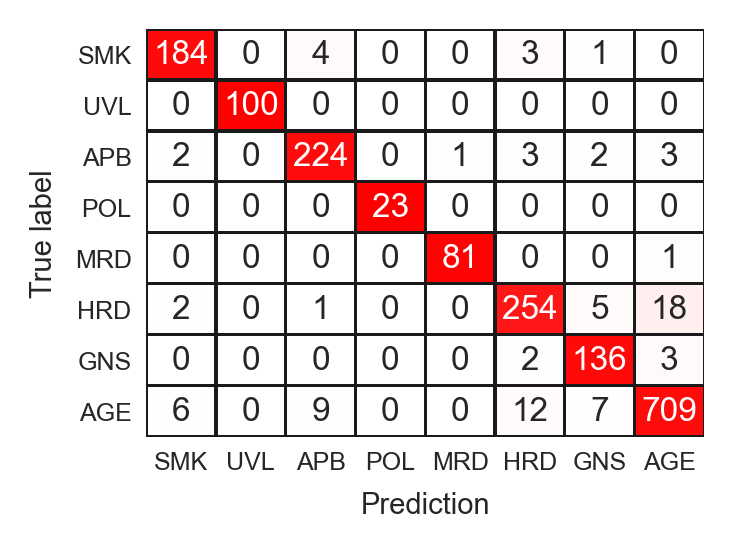

In [51]:
fig = plt.figure(figsize=(2.4,1.8))
ax = fig.add_subplot(1,1,1)
ax=sns.heatmap(data=cm_norm,vmin=0,vmax=1,
               annot=cm, cmap=wr, fmt="1d",
            annot_kws={"fontsize":8}
           ,cbar=False, linewidths=0.5,linecolor='k')
ax.set_title('',fontsize=7)
ax.set_xlabel('Prediction',fontsize=7)
ax.set_yticklabels(cluster_order,fontsize=6,rotation=0)
ax.set_xticklabels(cluster_order,fontsize=6,rotation=0)
ax.set_ylabel('True label',fontsize=7)
#plt.savefig(store+"Confusion_matrix_RFC.png",dpi=300,bbox_inches="tight")

In [52]:
acc_test=accuracy_score(y_pred=pred,y_true=y2)
acc_train=accuracy_score(y_pred=pred_train, y_true=y1)
print("Training acc={:.3f}".format(acc_train))
print("Test acc={:.3f}".format(acc_test))

Training acc=1.000
Test acc=0.953


## LRC

In [53]:
lrc.fit(X1,y1)
pred=lrc.predict(X2)
pred_train=lrc.predict(X1)

In [54]:
cm=confusion_matrix(pred, y2,labels=cluster_order)
cm=pd.DataFrame(cm,index=cluster_order,columns=cluster_order)
cm_norm=confusion_matrix(pred, y2,labels=cluster_order,normalize="true")
cm

,SMK,UVL,APB,POL,MRD,HRD,GNS,AGE
SMK,188,0,2,0,0,6,0,4
UVL,0,100,0,0,0,0,0,0
APB,0,0,230,0,1,4,1,2
POL,0,0,0,21,0,0,0,0
MRD,0,0,0,2,80,0,0,0
HRD,3,0,1,0,1,247,4,13
GNS,0,0,0,0,0,0,140,6
AGE,3,0,5,0,0,17,6,709


Text(30.750000000000004, 0.5, 'True label')

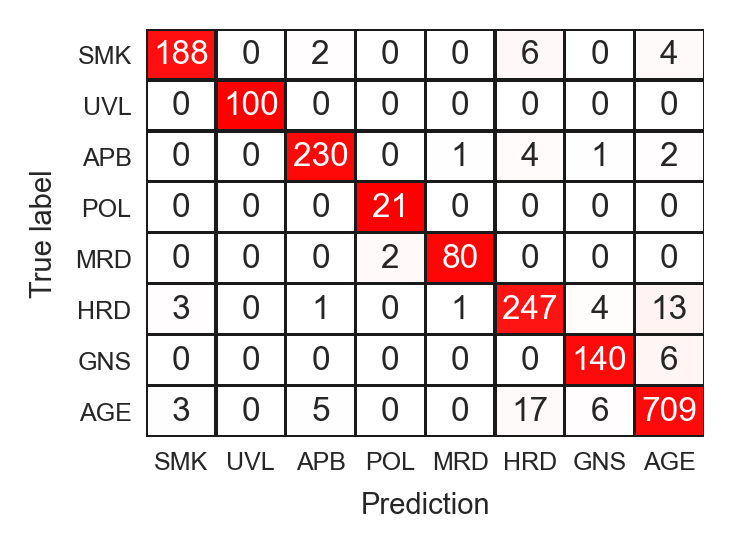

In [55]:
fig = plt.figure(figsize=(2.4,1.8))
ax = fig.add_subplot(1,1,1)
ax=sns.heatmap(data=cm_norm,vmin=0,vmax=1,
               annot=cm, cmap=wr, fmt="1d",
            annot_kws={"fontsize":8}
           ,cbar=False, linewidths=0.5,linecolor='k')
ax.set_title('',fontsize=7)
ax.set_xlabel('Prediction',fontsize=7)
ax.set_yticklabels(cluster_order,fontsize=6,rotation=0)
ax.set_xticklabels(cluster_order,fontsize=6,rotation=0)
ax.set_ylabel('True label',fontsize=7)
#plt.savefig(store+"Confusion_matrix_LRC.png",dpi=300,bbox_inches="tight")

In [56]:
acc_test=accuracy_score(y_pred=pred,y_true=y2)
acc_train=accuracy_score(y_pred=pred_train, y_true=y1)
print("Training acc={:.3f}".format(acc_train))
print("Test acc={:.3f}".format(acc_test))

Training acc=0.962
Test acc=0.955
